### Setup

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wearsed.training.metric import get_ahis, combine_fold_results

In [102]:
def get_ahi_severity_class(ahi):
    if ahi < 5:   # Normal
        return 0
    if ahi < 15:  # Mild
        return 1
    if ahi < 30:  # Moderate
        return 2
    return 3      # Severe

def get_ahi_severity_class_NBL(ahi, window=2):
    if ahi < 5 and ahi > 5 - window:
        return 1  # Mild
    if ahi > 5 and ahi < 5 + window:
        return 0  # Normal
    if ahi < 15 and ahi > 15 - window:
        return 2  # Moderate
    if ahi > 15 and ahi < 15 + window:
        return 1  # Mild
    if ahi < 30 and ahi > 30 - window:
        return 3  # Severe
    if ahi > 30 and ahi < 30 + window:
        return 2  # Moderate
    return -1     # No NBL

In [2]:
run, folds, epoch = 'attention_gates_bottleneck', [0, 1, 2, 3], 29
thr = 0.4

y_pred, y_true = combine_fold_results(run, folds, epoch)
ahis_pred, ahis_true = get_ahis(y_pred, y_true, thr)

### Plots

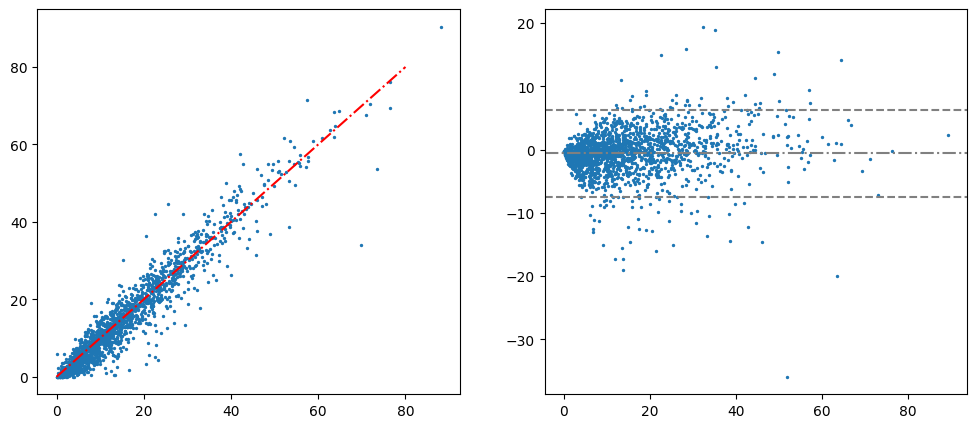

In [49]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.scatter(ahis_true, ahis_pred, s=2)
ax1.plot([0, 80], [0, 80], 'r-.')

mean = np.mean([ahis_pred, ahis_true], axis=0)
diff = np.array(ahis_pred) - np.array(ahis_true)
diff_mean, diff_std = np.mean(diff), np.std(diff, axis=0)
ax2.scatter(mean, diff, s=2)
ax2.axhline(diff_mean,                 color='gray', linestyle='-.')
ax2.axhline(diff_mean + 1.96*diff_std, color='gray', linestyle='--')
ax2.axhline(diff_mean - 1.96*diff_std, color='gray', linestyle='--')

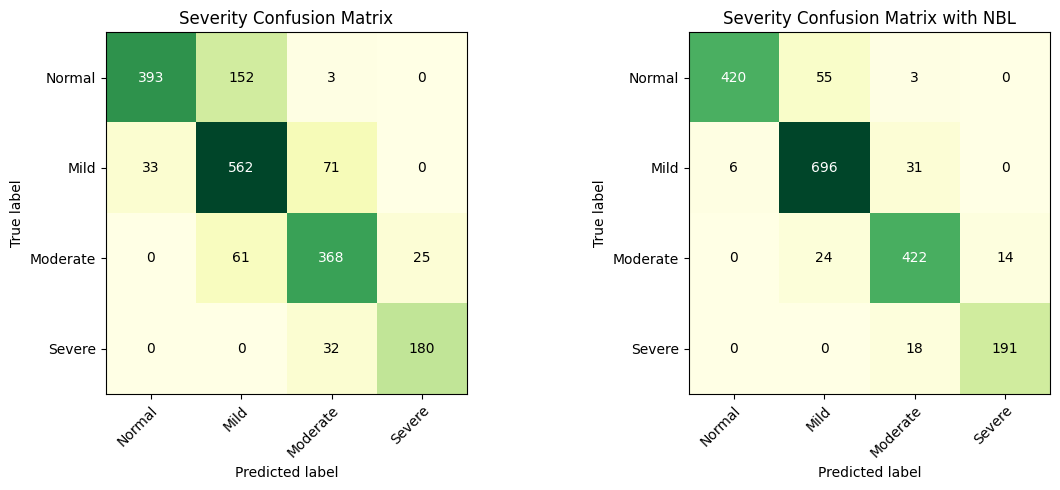

In [107]:
# Create Plot
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
true_labels = pred_labels = ['Normal', 'Mild', 'Moderate', 'Severe']
NBL_WINDOW = 2

# Get Severity classes with and without NBL
ahi_severitys_pred = [get_ahi_severity_class(ahi) for ahi in ahis_pred]
ahi_severitys_true = [get_ahi_severity_class(ahi) for ahi in ahis_true]
ahi_severitys_pred_NBL = []
for ahi, ahi_severity_true in zip(ahis_pred, ahi_severitys_true):
    hard_severity = get_ahi_severity_class(ahi)
    soft_severity = get_ahi_severity_class_NBL(ahi, window=NBL_WINDOW)
    if soft_severity == ahi_severity_true:
        ahi_severitys_pred_NBL.append(soft_severity)
    else:
        ahi_severitys_pred_NBL.append(hard_severity)

# Generate the confusion matrix
confusion_matrix = [[0]*4 for _ in range(4)]
for ahi_severity_pred, ahi_severity_true in zip(ahi_severitys_pred, ahi_severitys_true):
    confusion_matrix[ahi_severity_pred][ahi_severity_true] += 1
confusion_matrix_NBL = [[0]*4 for _ in range(4)]
for ahi_severity_pred, ahi_severity_true in zip(ahi_severitys_pred_NBL, ahi_severitys_true):
    confusion_matrix_NBL[ahi_severity_pred][ahi_severity_true] += 1

# Show Data
ax1.imshow(confusion_matrix, cmap='YlGn')
ax2.imshow(confusion_matrix_NBL, cmap='YlGn')

for i in range(len(true_labels)):
    for j in range(len(pred_labels)):
        text = ax1.text(j, i, confusion_matrix[i][j], ha='center', va='center', color='w' if confusion_matrix[i][j] > 300 else 'k')
for i in range(len(true_labels)):
    for j in range(len(pred_labels)):
        text = ax2.text(j, i, confusion_matrix_NBL[i][j], ha='center', va='center', color='w' if confusion_matrix_NBL[i][j] > 300 else 'k')

# Labels
for ax in [ax1, ax2]:
    ax.set_xticks(range(len(true_labels)), labels=true_labels, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(range(len(pred_labels)), labels=pred_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
ax1.set_title('Severity Confusion Matrix')
ax2.set_title('Severity Confusion Matrix with NBL')

plt.tight_layout()
plt.show()